In [3]:
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import torch.nn.functional as F
from sklearn.metrics import auc
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
sns.set()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [6]:
array_of_embeddings = [[None for x in range(4)] for y in range(50)]

In [7]:
path = r'C:\Users\Vineet Kumar Verma\Desktop\Major Part - 1\Face Matching\training\*'
person = []
row_index = 0
for path in glob.glob(path):
    
    person.append(os.path.basename(path))
    person_img_path = glob.glob(os.path.join(path, '*.jpg'))
    
    col_index = 0
    array_of_embeddings[row_index][col_index] = os.path.basename(path)
    
    for img_path in person_img_path:
        
        img = Image.open(img_path)
        img = img.resize((160, 160), resample = Image.LANCZOS)
        img = np.array(img)
        mean = img.mean()
        stddev = img.std()
        adjusted_stddev = max(stddev, 1.0/math.sqrt(img.size))
        img = (img - mean)/adjusted_stddev
        img = torch.from_numpy(img).float().to(device)
        img = img.permute(2, 0, 1)
        img_embedding = resnet(img.unsqueeze(0))
        
        col_index = col_index + 1
        array_of_embeddings[row_index][col_index] = img_embedding.cpu().detach().numpy()
        
    row_index = row_index + 1

In [8]:
array_of_embeddings = np.array(array_of_embeddings)
embedding_df = pd.DataFrame(data = array_of_embeddings[:, 1:], index = array_of_embeddings[:, 0], columns = ['Aadhar', 'PAN', 'Photo'])
embedding_df.head()

,Aadhar,PAN,Photo
100,"[[0.03119058, -0.05560177, -0.030275773, 0.038...","[[-0.02418485, -0.07964193, 0.014518557, 0.040...","[[-0.039655436, -0.043306023, -0.03753889, 0.0..."
144,"[[-0.008161513, -0.03272914, 0.008121692, 0.02...","[[0.002646978, 0.02329809, 0.011009869, 0.0430...","[[-0.09759647, 0.017898235, -0.04802947, 0.003..."
145,"[[0.05043205, -0.026571298, -0.033735234, 0.02...","[[0.026021136, -0.035495855, -0.05510301, 0.05...","[[0.044944916, -0.00026974885, -0.06317894, 0...."
15,"[[-0.0068920534, -0.034521084, -0.07286961, 0....","[[0.061966754, -0.0049707447, -0.09104561, -0....","[[0.06369612, 0.005499538, -0.09948078, -0.004..."
150,"[[-0.035022575, 0.019373562, -0.02466429, -0.0...","[[-0.03116064, 0.04016489, -0.043046765, 0.076...","[[-0.014748882, -0.010233911, -0.026496585, -0..."


In [9]:
def calculate_cosine_similarity_between_pair_of_arrays_of_embeddings(df_index, arr1, arr2):
    
    len_arr = len(arr1)
    arr = [[None for x in range(len_arr)] for y in range(len_arr)]
    arr = np.array(arr)
    
    similarity_df = pd.DataFrame(data = arr[:,:], index = df_index, columns = df_index)
    
    row = 0
    for embed1 in arr1:
        
        embed1 = torch.from_numpy(embed1).float().to(device)
        col = 0
        for embed2 in arr2:
            
            embed2 = torch.from_numpy(embed2).float().to(device)
            similarity_df.iloc[row, col] = F.cosine_similarity(embed1, embed2).cpu().detach().numpy()
            col = col + 1
        
        row = row + 1
    
    return similarity_df

In [10]:
def extract_all_diag_elements_and_max_in_each_col_except_diag_element(df, column_names):
    
    max_of_each_column = []
    for j in df.columns:
        arr = []
        for i in df.index:
            if i != j:
                arr.append(float(df.loc[i, j]))
            else:
                continue
        
        max_of_each_column.append(max(arr))
    
    
    comparison_df = pd.DataFrame(index = df.index, 
                                 columns = ['similarity between ' + column_names[0] + ' and ' + column_names[1] + ' of same person',
                                            'max (similarity between ' + column_names[0] + ' and ' + column_names[1] + ' of different person)'],
                                 dtype = float)
    comparison_df['similarity between ' + column_names[0] + ' and ' + column_names[1] + ' of same person'] = np.diag(df).astype(float)
    comparison_df['max (similarity between ' + column_names[0] + ' and ' + column_names[1] + ' of different person)'] = max_of_each_column
    return comparison_df

# Photo (ground truth) and Aadhar

In [11]:
aadhar_photo_similarity_df = calculate_cosine_similarity_between_pair_of_arrays_of_embeddings(embedding_df.index,
                                                                                            embedding_df['Photo'],
                                                                                            embedding_df['Aadhar'])
aadhar_photo_similarity_df.head()

,100,144,145,15,150,165,173,185,190,211,...,750,787,791,84,86,87,91,95,97,99
100,[0.58151835],[0.1904195],[0.3073697],[0.05112817],[0.23667696],[0.34121317],[0.29294488],[0.39255098],[0.24429248],[0.39360762],...,[0.12573905],[0.35411552],[0.354013],[0.39428055],[-0.060386486],[-0.08442741],[0.016803186],[0.2932895],[0.5544351],[0.15746851]
144,[0.27747402],[0.40285146],[0.06413279],[0.052036013],[0.10360913],[0.23064166],[0.48668194],[0.15115646],[-0.06435494],[0.054812375],...,[0.094966486],[0.35662055],[0.15482248],[0.2738946],[0.074721456],[0.29477137],[-0.037651446],[0.23197602],[0.2782849],[0.27204454]
145,[0.48184717],[0.33442745],[0.20423931],[0.14041439],[-0.121329434],[0.2243618],[0.34011534],[0.33208817],[0.24229339],[-0.028336812],...,[-0.09657165],[0.21799672],[0.41829064],[0.20974039],[0.13022557],[0.34797898],[0.17609188],[0.20393188],[0.43079937],[0.57789093]
15,[0.38418084],[0.080518275],[0.3049061],[0.28024307],[0.10220041],[0.13877583],[0.2546041],[0.06408824],[0.21449697],[0.062096484],...,[0.014776135],[0.045110244],[0.092281334],[0.07156711],[0.10364716],[0.3850168],[-0.043028526],[0.5992318],[0.19234057],[0.34869334]
150,[0.012700662],[0.3071134],[0.2599663],[0.18537167],[0.7318371],[0.44882792],[0.20694938],[0.10821664],[0.24909456],[0.47057644],...,[0.21543115],[0.28598124],[0.22489356],[0.26328236],[0.429473],[0.24247454],[0.17166135],[0.14341918],[0.0018937625],[0.13962786]


In [12]:
comparison_aadhar_photo = extract_all_diag_elements_and_max_in_each_col_except_diag_element(aadhar_photo_similarity_df, 
                                                                                            ['Aadhar', 'Photo'])
comparison_aadhar_photo.head()

,similarity between Aadhar and Photo of same person,max (similarity between Aadhar and Photo of different person)
100,0.581518,0.481847
144,0.402851,0.538896
145,0.204239,0.464815
15,0.280243,0.448763
150,0.731837,0.373463


In [13]:
arr1 = np.array(comparison_aadhar_photo[comparison_aadhar_photo.columns[0]])
arr2 = np.array(comparison_aadhar_photo[comparison_aadhar_photo.columns[1]])

In [14]:
labels_true = [1 for i in range(50)]
labels_false = [0 for i in range(50)]

In [15]:
X_train = np.concatenate((arr1, arr2)).reshape(-1, 1)
y_train = np.concatenate((labels_true, labels_false))

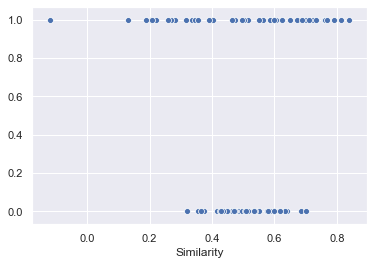

In [16]:
plot = sns.scatterplot(X_train.flatten(), y_train)
plt.xlabel('Similarity')
fig = plot.get_figure()
fig.savefig("output1.png", dpi=300)

In [17]:
logreg = LogisticRegression(solver = 'lbfgs')
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
probs = logreg.predict_proba(X_train)
probs = probs[:, 1]

In [19]:
auc = roc_auc_score(y_train, probs)
print('AUC: %.2f' % auc)

AUC: 0.58


In [86]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='LogisticRegression, AUC=0.55')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
    #fig = plot.get_figure()
    plt.savefig("output4.png", dpi=300)
    plt.show()

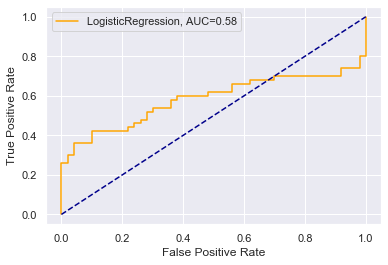

In [76]:
fpr, tpr, thresholds = roc_curve(y_train, probs)
plot_roc_curve(fpr, tpr)

# Photo (ground truth) and PAN

In [78]:
pan_photo_similarity_df = calculate_cosine_similarity_between_pair_of_arrays_of_embeddings(embedding_df.index,
                                                                                           embedding_df['Photo'],
                                                                                           embedding_df['PAN'])
pan_photo_similarity_df.head()

,100,144,145,15,150,165,173,185,190,211,...,750,787,791,84,86,87,91,95,97,99
100,[0.569613],[0.36276692],[0.42853174],[0.30944437],[0.09186682],[0.30306634],[0.044028375],[0.4305058],[0.32551527],[0.31519702],...,[0.2064858],[0.4022786],[0.2125223],[0.3182835],[0.49371436],[-0.046093386],[0.07251705],[0.12659831],[0.43543053],[0.1833803]
144,[0.27929842],[0.51299727],[0.46340334],[0.34450495],[0.13952886],[0.43391117],[0.21722294],[0.02278967],[0.0811299],[0.11930564],...,[0.119767494],[0.27256694],[0.20659526],[0.28364402],[0.5460394],[0.28102267],[0.29682913],[0.06127008],[0.16084385],[0.3711147]
145,[0.213435],[0.13197444],[0.43685198],[0.4107715],[0.08645578],[0.19931036],[-0.0060895747],[0.051013064],[0.24683061],[0.16481295],...,[0.0129960105],[0.20892781],[0.3141431],[-0.044879735],[0.34626934],[0.28317696],[0.11742291],[0.07961482],[0.16658452],[0.39405602]
15,[-0.10264892],[0.11649351],[0.3559432],[0.695203],[0.24397604],[0.08424336],[0.06249491],[0.13101217],[0.3168761],[-0.046820555],...,[0.052288823],[-0.0234912],[0.039187003],[0.14187732],[0.2897281],[0.32463557],[0.12550786],[0.4485688],[0.286621],[0.34062165]
150,[0.09440001],[0.079539575],[0.20909199],[0.08017993],[0.33966324],[0.14772652],[0.34182438],[-0.07011549],[0.081832394],[0.20612085],...,[0.070306055],[0.25704718],[0.058145203],[0.2290864],[0.016567422],[0.099532336],[0.19737582],[0.08357217],[0.18734755],[0.31748864]


In [79]:
comparison_pan_photo = extract_all_diag_elements_and_max_in_each_col_except_diag_element(pan_photo_similarity_df, ['PAN', 'Photo'])
comparison_pan_photo.head()

,similarity between PAN and Photo of same person,max (similarity between PAN and Photo of different person)
100,0.569613,0.608692
144,0.512997,0.533941
145,0.436852,0.583438
15,0.695203,0.567450
150,0.339663,0.491139


In [80]:
arr1 = np.array(comparison_pan_photo[comparison_pan_photo.columns[0]])
arr2 = np.array(comparison_pan_photo[comparison_pan_photo.columns[1]])

In [81]:
X_train = np.concatenate((arr1, arr2)).reshape(-1, 1)
y_train = np.concatenate((labels_true, labels_false))

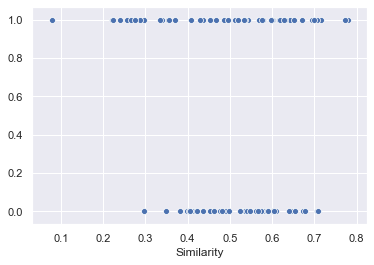

In [82]:
plot = sns.scatterplot(X_train.flatten(), y_train)
plt.xlabel('Similarity')
fig = plot.get_figure()
fig.savefig("output2.png", dpi=1200)

In [83]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 100)
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
probs = logreg.predict_proba(X_train)
probs = probs[:, 1]

In [85]:
auc = roc_auc_score(y_train, probs)
print('AUC: %.2f' % auc)

AUC: 0.55


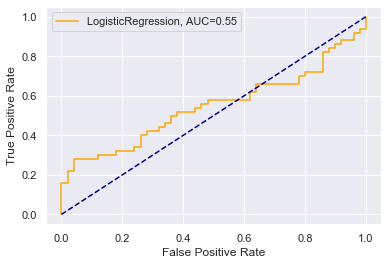

In [87]:
fpr, tpr, thresholds = roc_curve(y_train, probs)
plot_roc_curve(fpr, tpr)

# Aadhar and PAN

In [142]:
aadhar_pan_similarity_df = calculate_cosine_similarity_between_pair_of_arrays_of_embeddings(embedding_df.index,
                                                                                            embedding_df['PAN'],
                                                                                            embedding_df['Aadhar'])
aadhar_pan_similarity_df.head()

,100,144,145,15,150,165,173,185,190,211,...,65,720,73,743,744,750,787,791,84,86
100,[0.3672474],[0.2415284],[0.1343661],[-0.14896286],[0.057132274],[0.35320044],[0.41099596],[0.23121941],[0.07986722],[0.33063895],...,[-0.10668862],[0.2792077],[0.24976319],[0.24042234],[0.42865068],[0.14158835],[0.3706298],[0.16363],[0.41469264],[0.06711523]
144,[0.22001591],[0.39860344],[0.29353923],[0.049605574],[0.0798277],[0.30607212],[0.46930557],[0.38523602],[0.3426857],[0.29390943],...,[0.08156529],[0.3091106],[0.0025482702],[0.3933915],[0.59577954],[0.30045894],[0.4876324],[0.17314486],[0.565784],[-0.028539266]
145,[0.54889196],[0.17855032],[0.4724103],[0.3088307],[0.09497729],[0.635232],[0.5397641],[0.28486997],[0.32583296],[0.42990118],...,[0.111029744],[0.3847152],[0.4841836],[0.22755441],[0.38725427],[0.33298692],[0.57052416],[0.36967722],[0.34713608],[0.2762115]
15,[0.6442774],[0.14524738],[0.4001825],[0.36039698],[0.23734131],[0.3856585],[0.37270948],[0.3216282],[0.35012355],[0.3032155],...,[0.31870142],[0.43943596],[0.27785823],[0.3323632],[0.32886064],[0.18658395],[0.26452225],[0.2642633],[0.19117013],[0.19979471]
150,[0.07408964],[0.17118387],[0.33219904],[0.34905833],[0.2035962],[0.58203137],[0.3963403],[0.123175494],[0.26607317],[0.19872934],...,[0.36508384],[0.30462912],[0.15178896],[0.3120603],[0.10171045],[0.21318519],[0.24272129],[0.12984304],[0.14073096],[0.21359682]


In [143]:
comparison_aadhar_pan = extract_all_diag_elements_and_max_in_each_col_except_diag_element(aadhar_pan_similarity_df, ['Aadhar', 'PAN'])
comparison_aadhar_pan.head()

,similarity between Aadhar and PAN of same person,max (similarity between Aadhar and PAN of different person)
100,0.367247,0.644277
144,0.398603,0.637981
145,0.472410,0.572848
15,0.360397,0.603063
150,0.203596,0.399681


In [227]:
arr1 = np.array(comparison_aadhar_pan[comparison_aadhar_pan.columns[0]])
arr2 = np.array(comparison_aadhar_pan[comparison_aadhar_pan.columns[1]])

In [228]:
X_train = np.concatenate((arr1, arr2)).reshape(-1, 1)
y_train = np.concatenate((labels_true, labels_false))

Text(0.5, 0, 'Similarity')

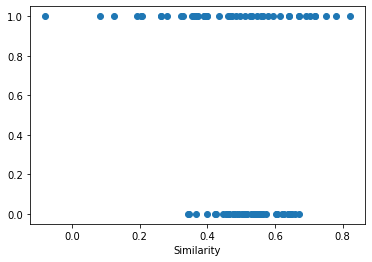

In [229]:
plt.plot(X_train, y_train, 'o')
plt.xlabel('Similarity')

In [230]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 100)
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [231]:
probs = logreg.predict_proba(X_train)
probs = probs[:, 1]

In [232]:
auc = roc_auc_score(y_train, probs)
print('AUC: %.2f' % auc)

AUC: 0.59


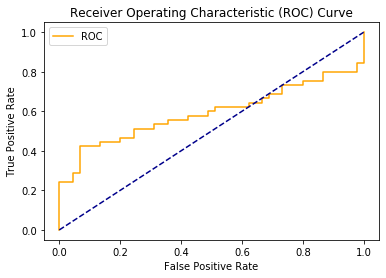

In [233]:
fpr, tpr, thresholds = roc_curve(y_train, probs)
plot_roc_curve(fpr, tpr)